Considering the quickstart_tutorial.py.

The goal is to create and train a neural network that classify one image in one out of ten possible classes.

To start we import everithing necesary to create a pytorch neural network.

In [1]:
# Pytorch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter # Only for plotting the schema
writer = SummaryWriter('torchlogs/') # This is only for tensorboard

# Other imports
import os # Not necesary
import matplotlib.pyplot as plt

This tutorial uses FashionMNIST dataset. This dataset consist on pictures of different clothes and their label. So, each data entry consist of one 28*28=784 image (X) in gray scale, and one scalar (y) ranging from 0 to 9.

Then we download the FashionMNIST dataset and plot it so we can see some of the images.

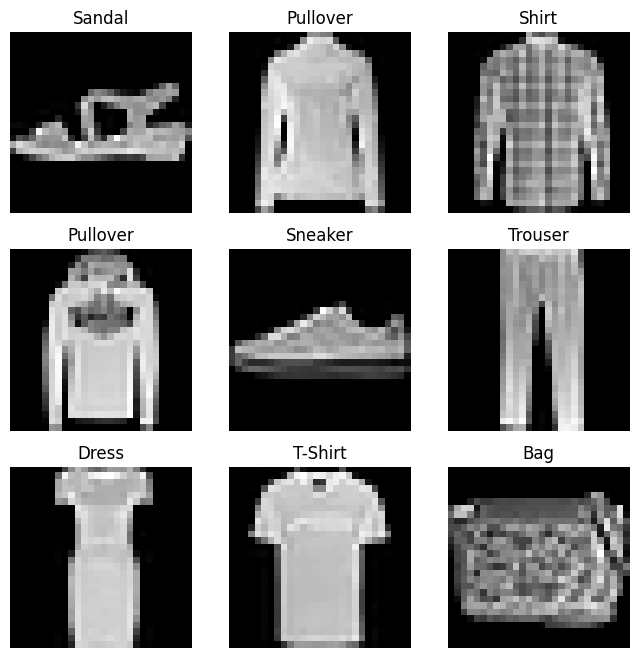

Training data length:  60000
Test data length:  10000


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Plot some of the images in the training data
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Print dataset length
print("Training data length: ", len(training_data))
print("Test data length: ", len(test_data))


Usually we use the 80% of our dataset as train data, and the 20% as test data. In this case we use 14% as test data.

Now we pass the Dataset as an argument to DataLoader. This is a class that allows to load and interate over the dataset. Supports automatic batching, sampling, shuffling and parallel data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

The use of a Dataset and DataLoader classes are not necesary to run a neural network, we can use tensors directly, but when we have a big amount of data, is better to create a custom Dataset and use a DataLoader.

A tensor is an multidimensional array of data (it works similar to a numpy array) and is the basic block of data we use to feed our Neural Network.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Here we can see the shape of X: 64 features of 1 x 28 x 28.
And the shape of y: 64 scalars (the label of every image in the batch).

To define a neural network in Pytorch, we create a class that inherits from "nn.Module". We define the layers of the network in the "__innit__" function and specify how data will pass through the network in the "foward" function. To acelerate operations in the neural netwok, we move it to the GPU if available using the method ".to('cuda')".

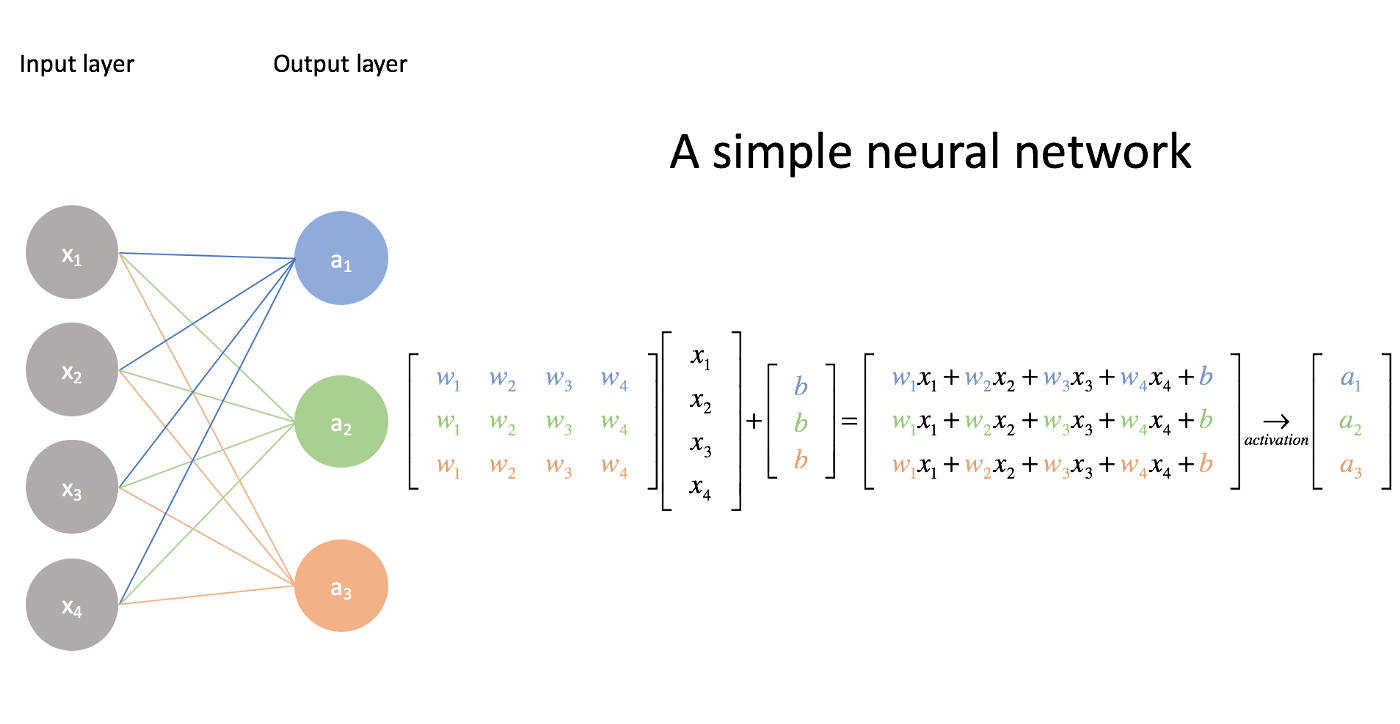

The neural network schematic is shown below.

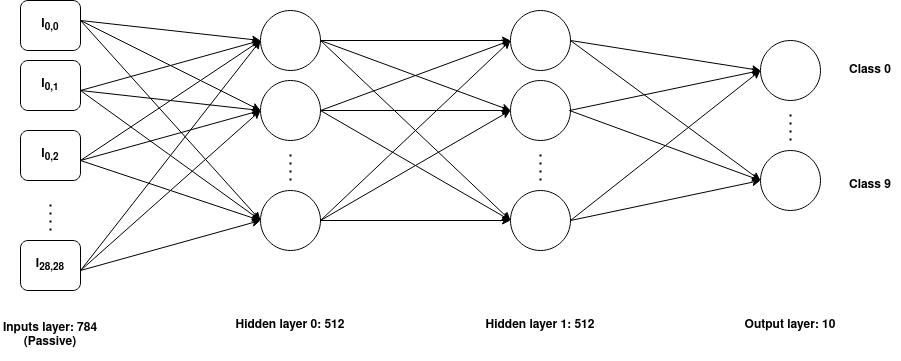

In [4]:
#Training in gpu takes more or less 19 seconds with batch size 64
#Training in cpu takes more or less 23 seconds with batch size 64

#Training in gpu takes more or less 18 seconds with batch size 128
#Training in cpu takes more or less 19 seconds with batch size 128

#Training in gpu takes more or less 16 seconds with batch size 10000
#Training in cpu takes more or less 18 seconds with batch size 10000

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__() # Innit the nn.Module
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        #x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

# Set the model to device
model = NeuralNetwork().to(device)
adamModel = NeuralNetwork().to(device)
print(model)

sample = torch.rand(1, 28, 28, device=device) # Sample for tensorboard
writer.add_graph(model, sample) # Add the model and sample to tensorboard
writer.close() # To run tensorboard, 'tensorboard --logdir torchlogs'

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


For train a model we need a "loss function" and an "optimizer".

A loss function is an object that includes the criterion that measure the error between the nn output and the known training output, and implements the backpropagation.

An optimizer is an algorithm that fits the nn parameters that minimize the loss function.

The most common loss functions and optimizers are already implemented in Pytorch (Gradient descent, Adam, etc).

In [5]:
loss_fn = nn.CrossEntropyLoss()
sdg_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
adam_optimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)

Now we can define the training loop and the test loop.

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

Training steps:

1. For all epoch:
2. For all batches:
3. Process the batch with the model (to get an output for each image in the batch).
4. Calculate loss function between model outputs and the known training outputs.
5. Clear gradient (set the gradients to zero).
6. Compute the gradients of the loss by means of a backpropagation.
7. Perform an optimization step (parameter uptadate)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    loss_count = []
    size = len(dataloader.dataset)
    model.train() # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X is the value of all images in the batch (64 x 1 x 28 x 28), y is the label of all images in the batch (64)
            
        # Compute prediction error
        pred = model(X) # The model predicts the class of each image, We send all the batch to the model
        loss = loss_fn(pred, y) # The loss function compares the model's prediction and the true label

        # Backpropagation
        optimizer.zero_grad() # Clear gradients from previous step
        loss.backward() # Compute gradients of the loss w.r.t. model parameters
        optimizer.step() # Perform a single optimization step (parameter update)

        loss_count.append(loss.item())
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X) 
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print("Memory allocated: ", torch.cuda.memory_allocated(device) / 1024**3, "GB")
    return loss_count

We also check the model's performance against the test dataset to ensure it is learning. 

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad(): # Disable gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch.

In [8]:
epoch = 5
# Using sdg optimizer
sdg_loss = []
epoch_values = []
for t in range(epoch):
    print("SDG Optimizer")
    print(f"Epoch {t+1} \n-------------------------------")
    loss_values = train(train_dataloader, model, loss_fn, sdg_optimizer)
    sdg_loss.extend(loss_values)
    test(test_dataloader, model, loss_fn)
    epoch_values.append(len(sdg_loss))
print("Done!")




SDG Optimizer
Epoch 1 
-------------------------------
loss: 2.293802  [    0/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.292725  [ 6400/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.272394  [12800/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.276498  [19200/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.258577  [25600/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.216118  [32000/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.226082  [38400/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.188589  [44800/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.182738  [51200/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.157739  [57600/60000]
Memory allocated:  0.007678985595703125 GB
Test Error: 
 Accuracy: 42.7%, Avg loss: 2.153865 

SDG Optimizer
Epoch 2 
-------------------------------
loss: 2.151498  [    0/60000]
Memory allocated:  0.007678985595703125 GB
loss: 2.155798  [ 6400/60000]
Memor

In [9]:
# Using adam optimizer
epoch = 5
adam_loss = []
for t in range(epoch):
    print("Adam Optimizer")
    print(f"Epoch {t+1} \n-------------------------------")
    
    loss_values = train(train_dataloader, adamModel, loss_fn, adam_optimizer)
    adam_loss.extend(loss_values)
    test(test_dataloader, adamModel, loss_fn)
print("Done!")

Adam Optimizer
Epoch 1 
-------------------------------
loss: 2.308322  [    0/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.543974  [ 6400/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.398999  [12800/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.488775  [19200/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.478949  [25600/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.451578  [32000/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.382893  [38400/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.533318  [44800/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.483659  [51200/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.524150  [57600/60000]
Memory allocated:  0.015164852142333984 GB
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.419694 

Adam Optimizer
Epoch 2 
-------------------------------
loss: 0.267432  [    0/60000]
Memory allocated:  0.015164852142333984 GB
loss: 0.353482  [ 6400/60000]
Mem

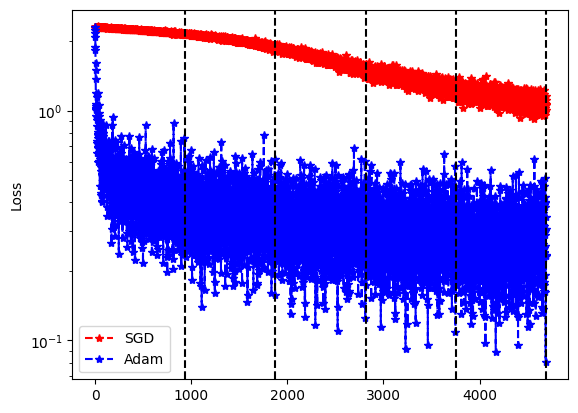

In [10]:
# Plot the loss function
plt.plot(sdg_loss, "--*", label='SGD', color='red')
plt.plot(adam_loss, "--*", label='Adam', color='blue')
for xc in epoch_values:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

Trained models can be saved.
A common way to save the model is, to save the internal state dictionary (containing the model parameters).

In [11]:
# Save the model
torch.save(model.state_dict(), "model.pth")

# Print the model's state_dict
print("Model's parameters:")
sum = 0
params = model.state_dict()
for param in params:
    sum += params[param].numel()
    print(param, "\t", params[param].size())
print("Total number of parameters: ", sum)
print("Saved PyTorch Model State to model.pth")

Model's parameters:
linear_relu_stack.0.weight 	 torch.Size([512, 784])
linear_relu_stack.0.bias 	 torch.Size([512])
linear_relu_stack.2.weight 	 torch.Size([512, 512])
linear_relu_stack.2.bias 	 torch.Size([512])
linear_relu_stack.4.weight 	 torch.Size([10, 512])
linear_relu_stack.4.bias 	 torch.Size([10])
Total number of parameters:  669706
Saved PyTorch Model State to model.pth


The process for loading a model includes re-creating the model structure and loading the state dictionary into it

In [12]:
cleanModel = NeuralNetwork()
cleanModel.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

cleanModel.eval() # Put the model in inference mode
x, y = test_data[0][0], test_data[0][1] # [n][0] is the image and [n][1] is the label index
with torch.no_grad():
    pred = cleanModel(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


We can see the prediction is correct!

Now let's experiment with the batch size. 

Sometimes a large batch size (faster processing time) can cause our model to not learn. That is because we don't make enough optimization steps to find the best parameters of the model. Otherwise, if our batch size is too small (slower processing time), the loss won't be representative for all the elements of the training dataset (sometimes it does, it depends on how the data is taken from the dataloader), and the optimizacion steps won't be correct.

Lets test and plot.


In [14]:

batch_num = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
accuracy_values = []
loss_test_values = []


for i in batch_num:
    test_batch_model = NeuralNetwork().to(device)
    sdg_optimizer = torch.optim.SGD(test_batch_model.parameters(), lr=1e-3)
    train_batch_dataloader = DataLoader(dataset = training_data, batch_size=i, shuffle=False)
    test_batch_dataloader = DataLoader(dataset=test_data, batch_size=i, shuffle=False)

    for t in range(epoch):
        print("SDG Optimizer")
        print(f"Epoch {t+1} \n-------------------------------")
        train(train_batch_dataloader, test_batch_model, loss_fn, sdg_optimizer)
        accuracy, loss_test = test(test_batch_dataloader, test_batch_model, loss_fn)

    accuracy_values.append(accuracy)
    loss_test_values.append(loss_test)



SDG Optimizer
Epoch 1 
-------------------------------
loss: 2.308180  [    0/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.268094  [  800/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.275274  [ 1600/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.262375  [ 2400/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.268240  [ 3200/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.209915  [ 4000/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.211001  [ 4800/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.167171  [ 5600/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.178520  [ 6400/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.170304  [ 7200/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.126613  [ 8000/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.146189  [ 8800/60000]
Memory allocated:  0.019989967346191406 GB
loss: 2.082455  [ 9600/60000]
Memory allocated:  0.019989967346191406

KeyboardInterrupt: 

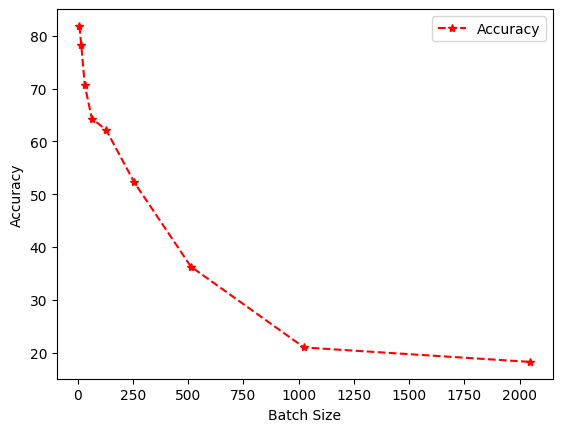

In [ ]:
# Plot accuracy vs batch size
plt.plot(batch_num, accuracy_values, "--*", label='Accuracy', color='red')
plt.ylabel('Accuracy')
plt.xlabel('Batch Size')
plt.legend()

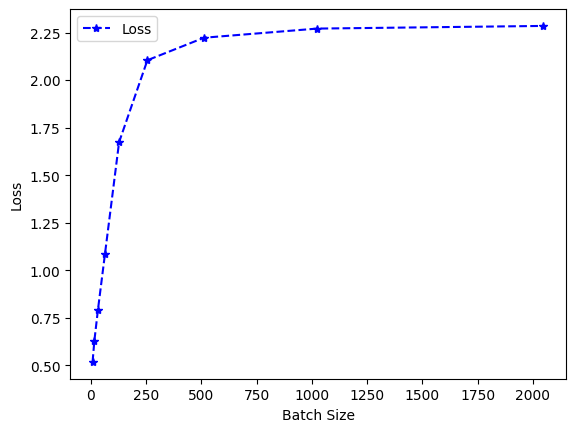

In [ ]:
# Plot loss vs batch size
plt.plot(batch_num, loss_test_values, "--*", label='Loss', color='blue')
plt.ylabel('Loss')
plt.xlabel('Batch Size')
plt.legend()

SDG Optimizer
Epoch 1 
-------------------------------
loss: 2.281122  [    0/60000]
loss: 2.378732  [  200/60000]
loss: 2.188584  [  400/60000]
loss: 1.676912  [  600/60000]
loss: 1.566099  [  800/60000]
loss: 0.840642  [ 1000/60000]
loss: 1.427131  [ 1200/60000]
loss: 0.806138  [ 1400/60000]
loss: 2.349607  [ 1600/60000]
loss: 1.053879  [ 1800/60000]
loss: 1.028239  [ 2000/60000]
loss: 0.277328  [ 2200/60000]
loss: 1.791302  [ 2400/60000]
loss: 1.880199  [ 2600/60000]
loss: 0.769011  [ 2800/60000]
loss: 1.394688  [ 3000/60000]
loss: 0.116821  [ 3200/60000]
loss: 0.963958  [ 3400/60000]
loss: 2.067086  [ 3600/60000]
loss: 0.868442  [ 3800/60000]
loss: 0.140702  [ 4000/60000]
loss: 0.364711  [ 4200/60000]
loss: 0.551446  [ 4400/60000]
loss: 0.380007  [ 4600/60000]
loss: 0.990118  [ 4800/60000]
loss: 0.658316  [ 5000/60000]
loss: 0.074785  [ 5200/60000]
loss: 0.618573  [ 5400/60000]
loss: 2.456690  [ 5600/60000]
loss: 0.080836  [ 5800/60000]
loss: 0.995976  [ 6000/60000]
loss: 0.030674 

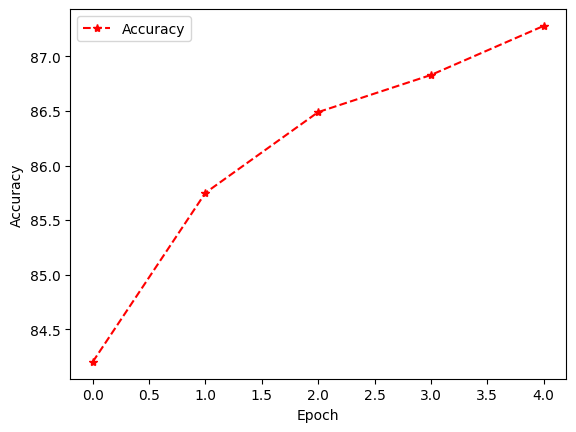

In [ ]:
batch_num = [2]
accuracy_values = []
loss_test_values = []


for i in batch_num:
    test_batch_model = NeuralNetwork().to(device)
    sdg_optimizer = torch.optim.SGD(test_batch_model.parameters(), lr=1e-2)
    train_batch_dataloader = DataLoader(dataset = training_data,batch_size=i)
    test_batch_dataloader = DataLoader(dataset=test_data, batch_size=i)

    for t in range(epoch):
        print("SDG Optimizer")
        print(f"Epoch {t+1} \n-------------------------------")
        train(train_batch_dataloader, test_batch_model, loss_fn, sdg_optimizer)
        accuracy, loss_test = test(test_batch_dataloader, test_batch_model, loss_fn)

        accuracy_values.append(accuracy)
        loss_test_values.append(loss_test)

# Plot accuracy vs batch size
plt.plot(accuracy_values, "--*", label='Accuracy', color='red')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
